# DES Mock Mass Map Summary Statistics Demo

This notebook showcases the GPU-accelerated `wl_stats_torch` package by computing mono-scale peak counts, multiscale starlet peak statistics, and wavelet L1 norms on a DES mock convergence map stored in the provided NumPy files.

## 1. Environment Setup
Ensure the package is installed (run `pip install -e .` in the project root if needed) and that the DES mock files are available under `/Users/atersenov/Data/example_catalogs/example_mass_maps/`.

In [1]:
import numpy as np
import torch
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

from wl_stats_torch import WLStatistics
from wl_stats_torch.visualization import (
    plot_peak_histograms,
    plot_l1_norms,
    plot_wavelet_scales,
    plot_snr_map,
    plot_comparison,
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cpu


## 2. Select and Load a DES Mock Map
Adjust `SELECTED_R` to choose the desired realization. The helper code below lists all available files matching the naming pattern so you can choose interactively if needed.

In [2]:
DATA_DIR = Path('/Users/atersenov/Data/example_catalogs/example_mass_maps')
FILE_TEMPLATE = 'DES_MocksCat_fid_a_4_Bin1_LOS1_R{idx}_ks_run4.npy'

available_files = sorted(DATA_DIR.glob('DES_MocksCat_fid_a_4_Bin1_LOS1_R*_ks_run4.npy'))
print(f'Found {len(available_files)} matching files in {DATA_DIR}')
if available_files:
    print('Example files:')
    for sample in available_files[:5]:
        print('  ', sample.name)

SELECTED_R = 1  # <-- change this index to load a different realization
npy_path = DATA_DIR / FILE_TEMPLATE.format(idx=SELECTED_R)

if not npy_path.exists():
    raise FileNotFoundError(
        f'Data file {npy_path} not found. Update SELECTED_R or verify the path.'
    )

print(f'Using map: {npy_path.name}')

Found 19 matching files in /Users/atersenov/Data/example_catalogs/example_mass_maps
Example files:
   DES_MocksCat_fid_a_4_Bin1_LOS1_R10_ks_run4.npy
   DES_MocksCat_fid_a_4_Bin1_LOS1_R11_ks_run4.npy
   DES_MocksCat_fid_a_4_Bin1_LOS1_R12_ks_run4.npy
   DES_MocksCat_fid_a_4_Bin1_LOS1_R13_ks_run4.npy
   DES_MocksCat_fid_a_4_Bin1_LOS1_R14_ks_run4.npy
Using map: DES_MocksCat_fid_a_4_Bin1_LOS1_R1_ks_run4.npy


## 3. Load Map and Inspect Basic Statistics
Here we load the selected mass map, convert it to a PyTorch tensor, and build a default noise model. You can replace the noise estimate with domain-specific knowledge if available.

In [3]:
map_np = np.load(npy_path)
if map_np.ndim != 2:
    raise ValueError(f'Expected a 2D map, got shape {map_np.shape}')

kappa_map = torch.from_numpy(map_np).float().to(device)
height, width = kappa_map.shape

noise_sigma_value = float(map_np.std())
sigma_map = torch.full_like(kappa_map, noise_sigma_value)
mask = torch.ones_like(kappa_map)

print(f'Map shape: {kappa_map.shape}')
print(f'min / max: {map_np.min():.4e} / {map_np.max():.4e}')
print(f'mean / std: {map_np.mean():.4e} / {map_np.std():.4e}')
print(f'Assumed noise sigma: {noise_sigma_value:.4e}')

Map shape: torch.Size([600, 600])
min / max: -9.6683e-01 / 9.5382e-01
mean / std: -1.1733e-04 / 1.2980e-01
Assumed noise sigma: 1.2980e-01


## 4. Visualize the Input Map
We smooth the visualization slightly to highlight large-scale structures.

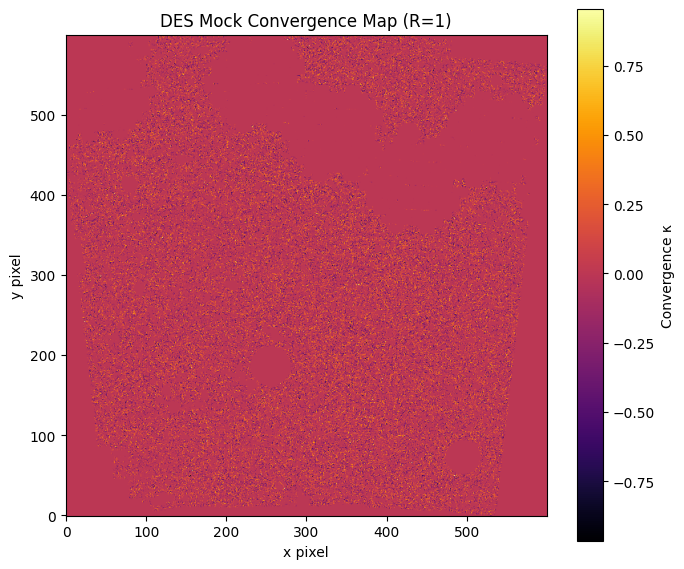

In [5]:
plt.figure(figsize=(7, 6))
plt.imshow(kappa_map.cpu().numpy(), origin='lower', cmap='inferno')
plt.colorbar(label='Convergence κ')
plt.title(f'DES Mock Convergence Map (R={SELECTED_R})')
plt.xlabel('x pixel')
plt.ylabel('y pixel')
plt.tight_layout()
plt.show()

## 5. Run Starlet-Based Summary Statistics
We now compute mono-scale peak counts, multiscale wavelet peak histograms, and wavelet L1 norms using the GPU-accelerated `WLStatistics` pipeline.

In [6]:
n_scales = 5
stats = WLStatistics(n_scales=n_scales, device=device, pixel_arcmin=1.0)

results = stats.compute_all_statistics(
    kappa_map,
    sigma_map,
    mask=mask,
    min_snr=-2.0,
    max_snr=6.0,
    n_bins=31,
    l1_nbins=40,
    compute_mono=True,
    mono_smoothing_sigma=2.0,
    verbose=True,
)

Computing wavelet transform...
Computing wavelet peak counts...
Scale 1: Min SNR = -6.0556, Max SNR = 6.3110
Scale 2: Min SNR = -4.9291, Max SNR = 4.9161
Scale 3: Min SNR = -6.3139, Max SNR = 6.5752
Scale 4: Min SNR = -11.4440, Max SNR = 9.2748
Scale 5: Min SNR = -20.1517, Max SNR = 23.9020
Computing wavelet L1-norms...
Computing mono-scale peaks...
✓ All statistics computed!


## 6. Inspect Key Outputs
Below we summarize the number of detected peaks per starlet scale and display the mono-scale histogram.

Scale 1: 29268 peaks (max SNR = 6.31)
Scale 2: 10441 peaks (max SNR = 4.92)
Scale 3: 2767 peaks (max SNR = 6.58)
Scale 4: 739 peaks (max SNR = 9.27)
Scale 5: 173 peaks (max SNR = 23.90)


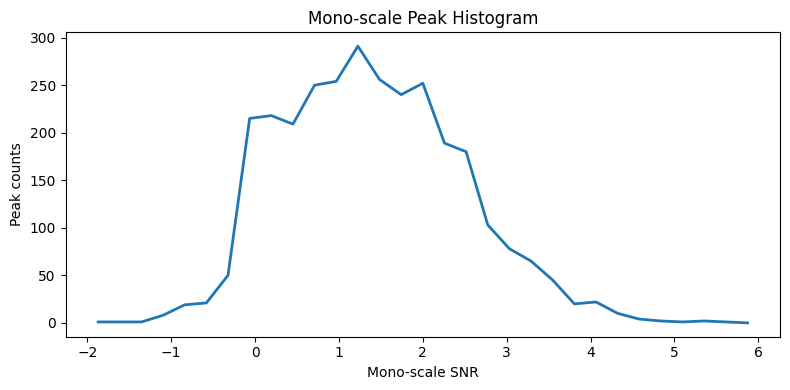

In [17]:
peak_bins = results['peak_bins']
wavelet_peak_counts = results['wavelet_peak_counts']
wavelet_peak_positions = results['wavelet_peak_positions']
wavelet_peak_heights = results['wavelet_peak_heights']
snr_cube = results['snr']
wavelet_l1_norms = results['wavelet_l1_norms']
l1_bins = results['l1_bins']

for idx, counts in enumerate(wavelet_peak_counts, start=1):
    total_peaks = int(counts.sum().item())
    max_height = float(wavelet_peak_heights[idx-1].max().item()) if len(wavelet_peak_heights[idx-1]) else float('nan')
    print(f'Scale {idx}: {total_peaks} peaks (max SNR = {max_height:.2f})')

plt.figure(figsize=(8, 4))
plt.plot(results['mono_peak_bins'].cpu(), results['mono_peak_counts'].cpu(), linewidth=2)
# plt.yscale('log')
plt.xlabel('Mono-scale SNR')
plt.ylabel('Peak counts')
plt.title('Mono-scale Peak Histogram')
plt.tight_layout()
plt.show()


## 7. Visualize Multiscale Statistics
We plot the peak-count histograms, L1 norms, and selected SNR maps with detected peaks.

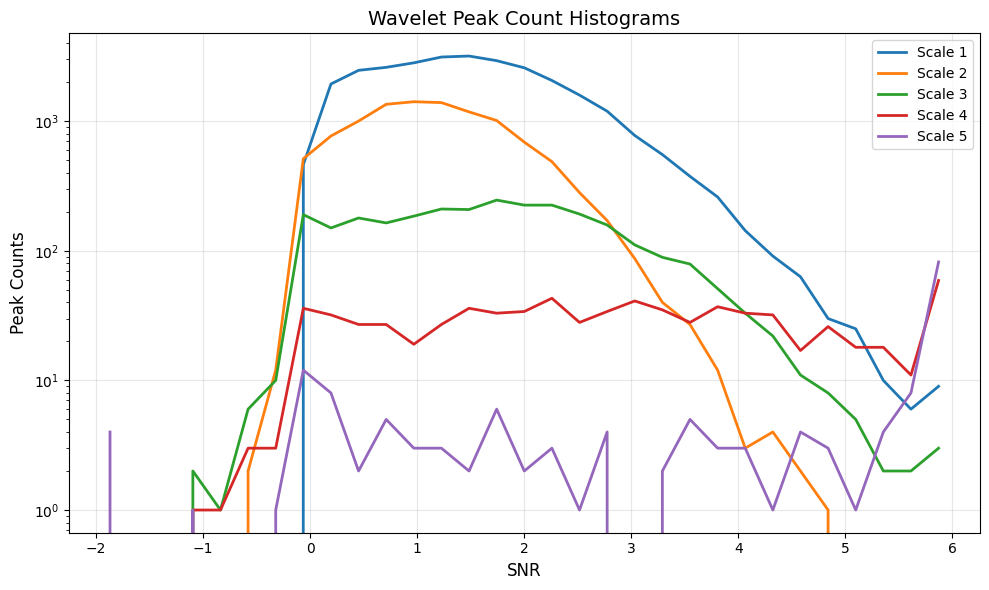

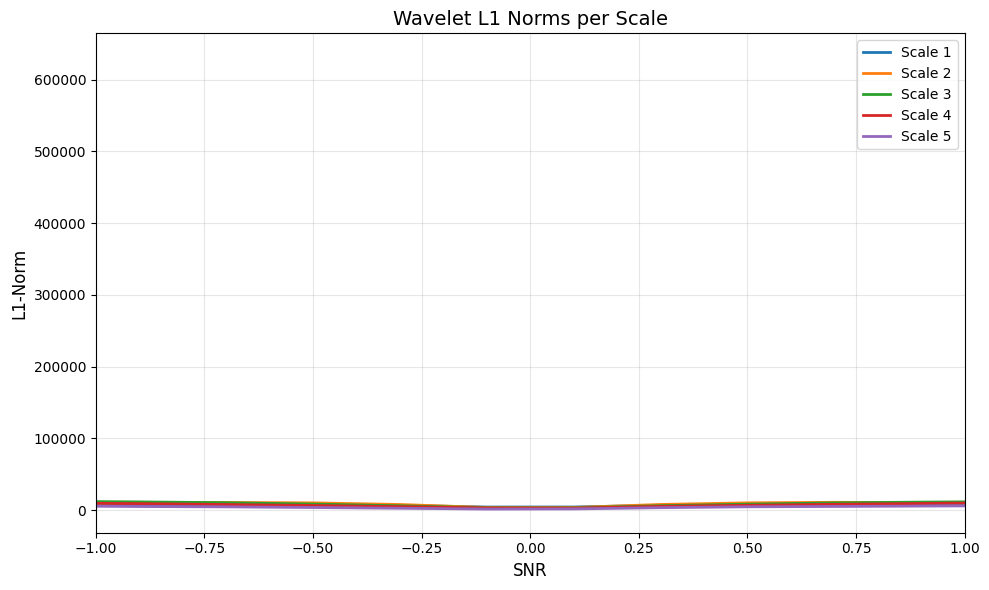

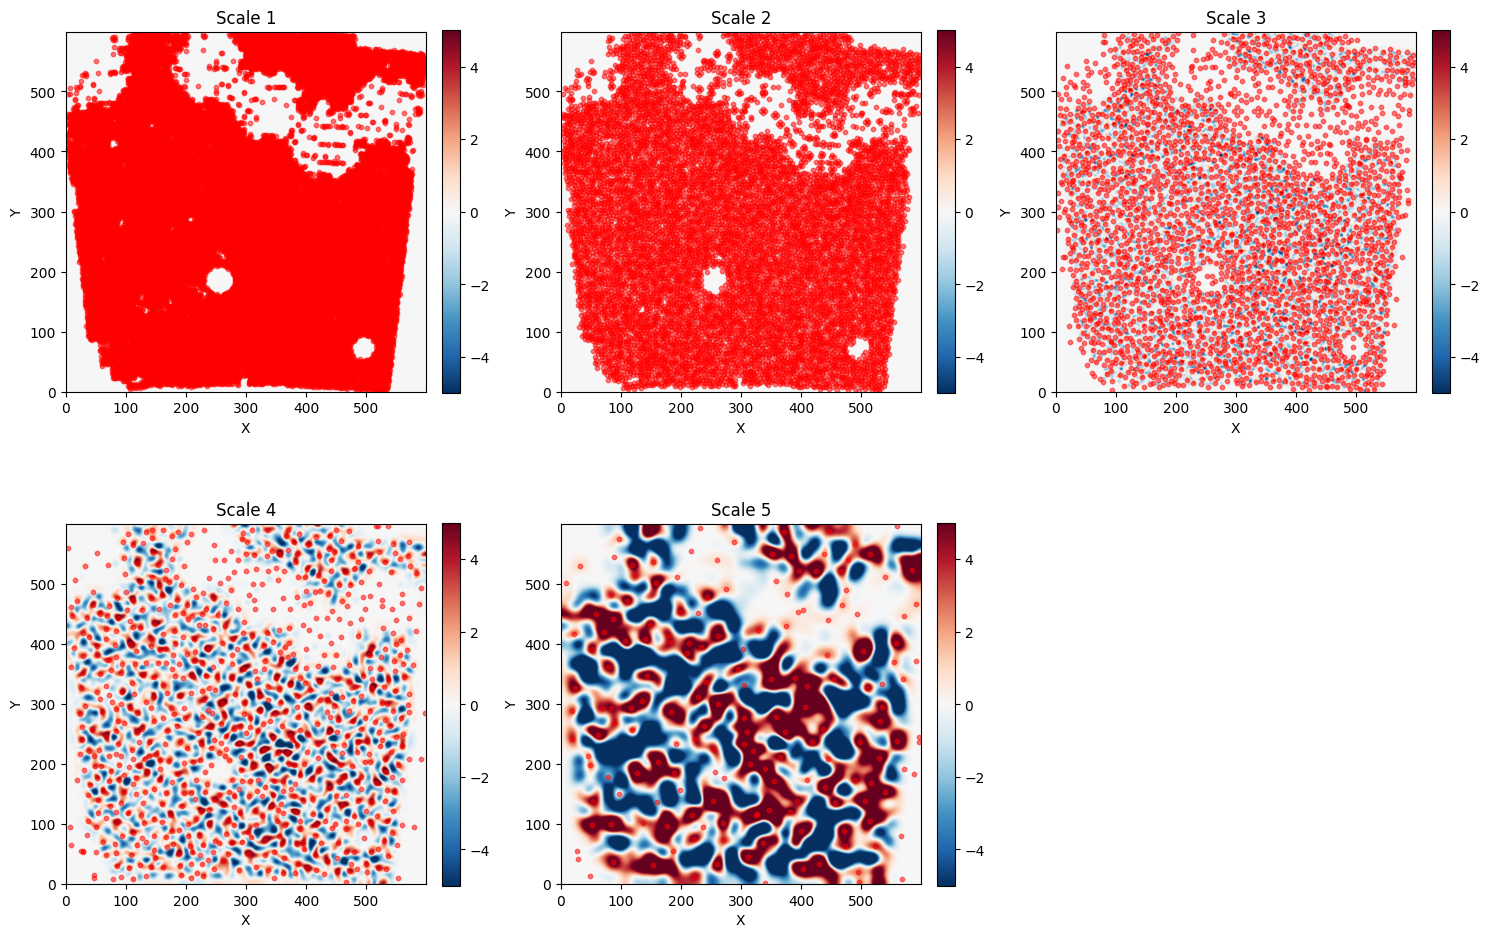

In [24]:
plot_peak_histograms(
    peak_bins.cpu(),
    [pc.cpu() for pc in wavelet_peak_counts],
    title='Wavelet Peak Count Histograms',
    log_scale=True,
    figsize=(10, 6)
)

plot_l1_norms(
    [bins.cpu() for bins in results['l1_bins']],
    [l1.cpu() for l1 in results['wavelet_l1_norms']],
    title='Wavelet L1 Norms per Scale',
    figsize=(10, 6),
    xlim=(-1, 1)
)

plot_wavelet_scales(
    snr_cube.cpu(),
    peak_positions=[pos.cpu() for pos in wavelet_peak_positions],
    cmap='RdBu_r',
    vmin=-5,
    vmax=5,
    figsize=(15, 10),
    mark_peaks=True
)

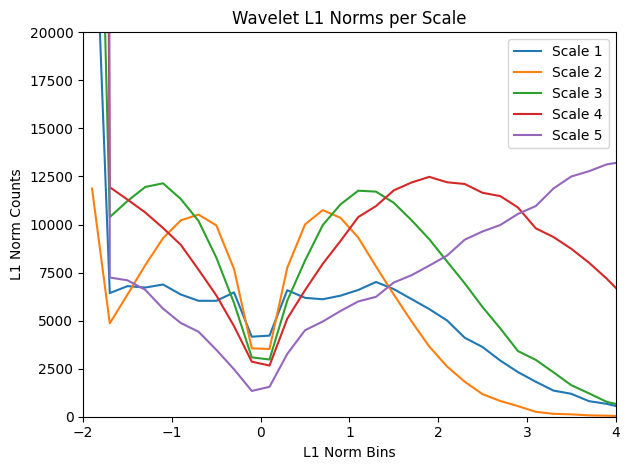

In [29]:
# plot_l1_norms(
#     [bins.cpu() for bins in results['l1_bins']],
#     [l1.cpu() for l1 in results['wavelet_l1_norms']],
#     title='Wavelet L1 Norms per Scale',
#     figsize=(10, 6),
#     xlim=(-1, 1)
# )

for i in range(n_scales):
    plt.plot(l1_bins[i].cpu(), wavelet_l1_norms[i].cpu(), label=f'Scale {i+1}')
plt.xlim(-2, 4)
plt.ylim(0, 20000)
plt.xlabel('L1 Norm Bins')
plt.ylabel('L1 Norm Counts')
plt.title('Wavelet L1 Norms per Scale')
plt.legend()
plt.tight_layout()
plt.show()